<a href="https://colab.research.google.com/github/doeungim/ADP_DE/blob/main/ADP_SET_1_DE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SONY/ADP_SET_1/data/bitcoin_mock.csv')

In [4]:
df.head(4)

,datetime,open,high,low,close,volume
0,2022-01-01 00:00:00,46216.93,46271.08,46208.37,46250.00,40.57574
1,2022-01-01 00:01:00,46250.00,46344.23,46234.39,46312.76,42.38106
2,2022-01-01 00:02:00,46312.76,46381.69,46292.75,46368.73,51.29955
3,2022-01-01 00:03:00,46368.73,46391.49,46314.26,46331.08,30.45894


In [5]:
df['datetime']= pd.to_datetime(df['datetime'])

## 1. 1분간격으로 존재하는지 = 차이를 확인
df['diff'] =  df['datetime'].diff(1).dt.seconds

## 2. 확인 - 60초와 120초
display(df['diff'].value_counts() )

## 3. Solution : 120초를 가지는 데이터의 인덱스를 추출

import datetime

lst = []
idx_lst = [0] + list(df[df['diff'] == 120].index)
print(idx_lst)

for i, idx in enumerate(idx_lst[:-1]) :
  target_df = df.iloc[idx_lst[i]: idx_lst[i+1]]
  empty_df = pd.DataFrame()
  next_min = (target_df['datetime'] + datetime.timedelta(minutes = 1)).values[-1]
  empty_df['datetime'] = [next_min]

  concat_df = pd.concat([target_df, empty_df]).reset_index(drop= True)
  lst.append(concat_df)

lst.append(df.iloc[575932:])
total = pd.concat(lst).reset_index(drop = True).drop('diff', axis = 1)


# 1. interploate 결측 처리 : datetime이 index로 되어야함
t = total.set_index('datetime').interpolate().reset_index()

# 2. fillna 사용해보기 : datetime을 제외한 컬럼을 찾기

total.iloc[:,1:] =  total.iloc[:,1:].combine_first((total.iloc[:,1:].fillna(method='bfill') + total.iloc[:,1:].fillna(method='ffill'))/2)
t = total.copy()

,count
diff,
60.0,613102
120.0,25


[0, 21440, 21757, 73347, 117580, 128033, 148204, 167296, 176478, 188309, 229511, 246312, 293361, 294091, 365199, 371389, 401645, 412633, 413808, 436955, 457592, 470904, 491242, 491733, 513277, 575932]


<ipython-input-5-0f4d828e7c1b>:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  total.iloc[:,1:] =  total.iloc[:,1:].combine_first((total.iloc[:,1:].fillna(method='bfill') + total.iloc[:,1:].fillna(method='ffill'))/2)


In [6]:
## option 2) datetime 처음과 끝을 1분간간격으로
print( df['datetime'].max() , df['datetime'].min())

date_range = pd.DataFrame(pd.date_range(start = '2022-01-01 00:00:00' , end = '2023-03-02 19:12:00', freq = '1T' ), columns = ['datetime'])

total = pd.merge(total, df , how = 'outer').drop(columns = 'diff', axis =1)

t = total.set_index('datetime').interpolate().reset_index()


2023-03-02 19:12:00 2022-01-01 00:00:00


t(분)시점에서 close 값에 대한 t(분)시점의 5분,120분 이동평균값을 각각 't_5', 't_120'으로 컬럼으로 t-1(분)시점의 5분,120분 이동평균값을 각각 't-1_5', 't-1_120'으로 컬럼

In [7]:
# 1. 5분 이동 평균

t['t_5'] = t['close'].rolling(5).mean()
t['t_120'] = t['close'].rolling(120).mean()

# 2. t-1분 시점으로 t-1_5

t['t_1_5'] = t['t_5'].shift(1)
t['t_1_120'] = t['t_120'].shift(1)

# 3. Dropna 로 뺴기
t = t.dropna().reset_index(drop = True)

- t(분)시점에서 5분 이동평균값(t_5)은 120분 이동평균값(t_120)보다 높고 t-1의 5분 이동평균값(t-1_5)은 120분 이동평균값(t-1_120)보다 낮은 경우 : 'buy' # 매수
- t(분)시점에서 5분 이동평균값(t_5)은 120분 이동평균값(t_120 보다 낮고 t-1의 5분 이동평균값(t-1_5)은 120분 이동평균값(t-1_120)보다 높은 경우 : 'sell' # 매도
- 그외 'stay'

In [8]:
#t['t_5'] >= t['t_120'] & ['t_1_5'] < ['t_1_120'] : buy
#t['t_5'] < t['t_120'] & ['t_1_5'] >= ['t_1_120'] : sell

t['algo']= t.apply(lambda x : 'buy' if ( x['t_5'] >= x['t_120'] ) & (x['t_1_5'] < x['t_1_120']) else ('sell' if ( x['t_5'] < x['t_120'] ) & (x['t_1_5'] >= x['t_1_120']) else 'stay' ), axis =1)

t['algo'].value_counts()

t['t_10'] = t['open'].shift(-10)

In [9]:
""" 여부가 'buy' 이고 t+10(분) open >= t(분) close : 'profit'
여부가 'buy' 이고 t+10(분) open < t(분) close : 'loss'
여부가 'sell' 이고 t+10(분) open >= t(분) close : 'loss'
여부가 'sell' 이고 t+10(분) open < t(분) close : 'profit'
여부가 'stay' 이면 : 'stay'
위의 조건으로 컬럼값을 채운 """

def result_return(x) :

  if x['algo'] == 'buy' :
    if x['t_10'] >= x['close'] :
      return 'profit'
    else :
      return 'loss'

  elif x['algo'] == 'sell' :
    if x['t_10'] >= x['close'] :
      return 'loss'
    else :
      return 'profit'

  else :
    return 'stay'

t['result'] = t[['algo', 't_10', 'close']].apply(result_return, axis = 1)
pd.crosstab(t['algo'], t['result'])

result,loss,profit,stay
algo,,,
buy,3756,3563,0
sell,3793,3527,0
stay,0,0,598429


2022-01-01 08:00:00 ~ 2022-01-01 15:00:00 시간대의 close값의 선형 그래프

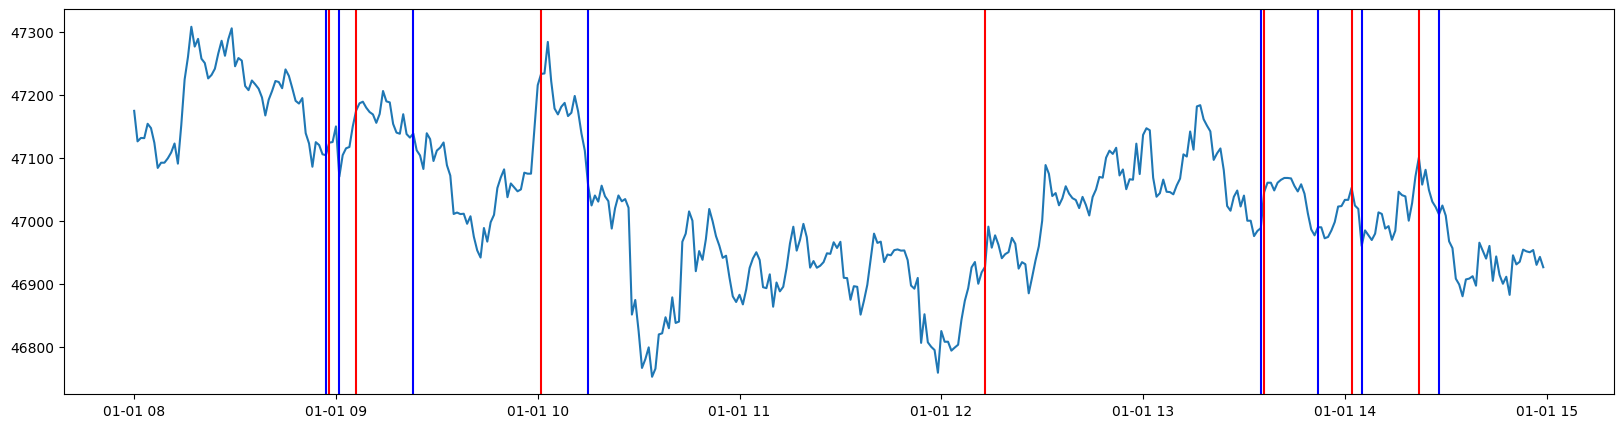

In [10]:

import matplotlib.pyplot as plt

g_df = t.loc[(t['datetime'] >= pd.to_datetime('2022-01-01 08:00:00')) &( t['datetime'] <  pd.to_datetime('2022-01-01 15:00:00'))]

fig, ax = plt.subplots(figsize = (20, 5))
plt.plot(g_df['datetime'], g_df['close'])

for i in range(len(g_df)) :
  if g_df['algo'].iloc[i] == 'buy' :
    plt.axvline(x = g_df['datetime'].iloc[i], color = 'red')

  elif g_df['algo'].iloc[i] == 'sell' :
    plt.axvline(x = g_df['datetime'].iloc[i], color = 'blue')
plt.show()



In [11]:

## 컬럼 추가
t['oc'] = t['open'] - t['close']
t['tt5_oc'] = t['close'] - t['close'].shift(5)
t = t.dropna().reset_index(drop =True)


model_df = t[['datetime', 'open', 'oc', 'tt5_oc', 'algo','result']]
## lost,, profit만 있는 것들
model_df = model_df[model_df.result.isin(['loss','profit'])]

## 2022년 2월 12월 : train
train = model_df.loc[(model_df['datetime'].dt.year == 2022) & (model_df['datetime'].dt.month.isin(range(2,13)))]


##  2023년 1~2월의 데이터를 평가 데이터
test = model_df.loc[(model_df['datetime'].dt.year == 2023) & (model_df['datetime'].dt.month.isin(range(1,3)))]
#test.datetime.dt.month.value_counts()

x_train = pd.get_dummies(train.drop(columns = ['result','datetime']), dtype = 'int')
y_train = train['result'].map({'loss' : 0 , 'profit' :1})


x_test = pd.get_dummies(test.drop(columns = ['result','datetime']), dtype = 'int')
y_test = test['result'].map({'loss' : 0 , 'profit' :1})

print(x_test.shape, y_test.shape)

(2095, 5) (2095,)


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# 2. Scaling

ss = StandardScaler()
scaled_train = pd.DataFrame(ss.fit_transform(x_train[['open','oc','tt5_oc']]) ,columns = x_train[['open','oc','tt5_oc']].columns )
scaled_x_train = pd.concat([scaled_train ,x_train[['algo_buy',	'algo_sell']].reset_index(drop=True) ], axis = 1)


scaled_test = pd.DataFrame(ss.fit_transform(x_test[['open','oc','tt5_oc']]) ,columns = x_train[['open','oc','tt5_oc']].columns )
scaled_x_test = pd.concat([scaled_test ,x_test[['algo_buy',	'algo_sell']].reset_index(drop=True) ], axis = 1)


# scaled_x_train, y_train, scaled_x_test , y_test

rf = RandomForestClassifier()

rf.fit(x_train,y_train)
rf_predict_proba = rf.predict_proba(x_test)
rf_predict_df = pd.DataFrame(rf_predict_proba)
rf_predict_df['label'] = rf_predict_df[1].map(lambda x : 1 if x >=0.6 else 0)
accuracy_score(y_test,rf_predict_df['label'])

0.4863961813842482

In [13]:
scv = SVC()

scv.fit(scaled_x_train, y_train)
scv_pred = scv.predict(scaled_x_test)
accuracy_score(y_test,scv_pred)

0.5279236276849641

In [14]:
df= pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE/main/ADP_SET1/data/user_data.csv')
df.head(4)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12


In [15]:
#결측치 제거
df['CREDIT_LIMIT'] =df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean())
df['MINIMUM_PAYMENTS'] =df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].mean())


<Axes: >

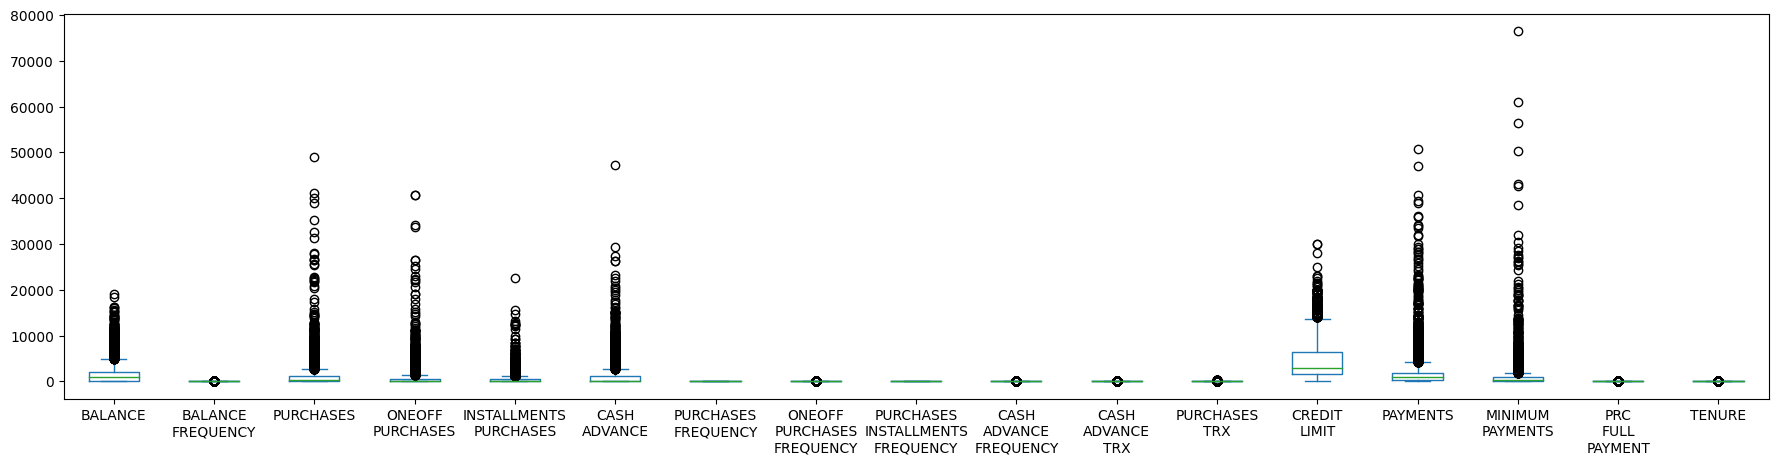

In [16]:
import matplotlib.pyplot as plt

fig_df = df.drop(columns = ['CUST_ID'], axis =1 )
fig, ax = plt.subplots(figsize = (22, 5))

fig_df.columns = [x.replace('_','\n') for x in fig_df.columns]
fig_df.plot(kind = 'box', ax = ax)

<Axes: >

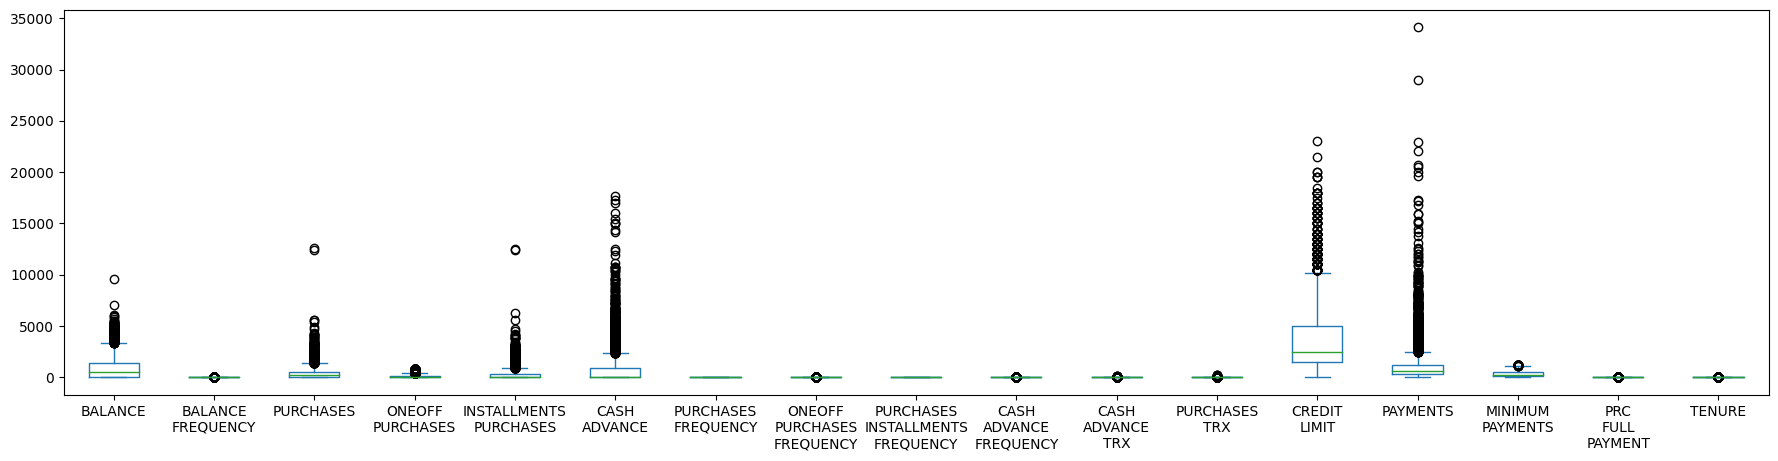

In [17]:
## 이상치 처리 - 지정 컬럼만,

def iqr (df, column) :

  q1 = df[column].quantile(0.25)
  q3 = df[column].quantile(0.75)

  iqr = q3 - q1
  lower = q1 - iqr * 1.5
  upper = q1 + iqr * 1.5

  return_df = df[(df[column]> lower) & (df[column] < upper) ]
  return return_df

df_f1 = iqr(df, 'MINIMUM_PAYMENTS')
df_f2 = iqr(df_f1, 'ONEOFF_PURCHASES')


df_f2 = df_f2.drop(columns = ['CUST_ID'], axis =1 )
fig, ax = plt.subplots(figsize = (22, 5))

df_f2.columns = [x.replace('_','\n') for x in df_f2.columns]
df_f2.plot(kind = 'box', ax = ax)

<Axes: >

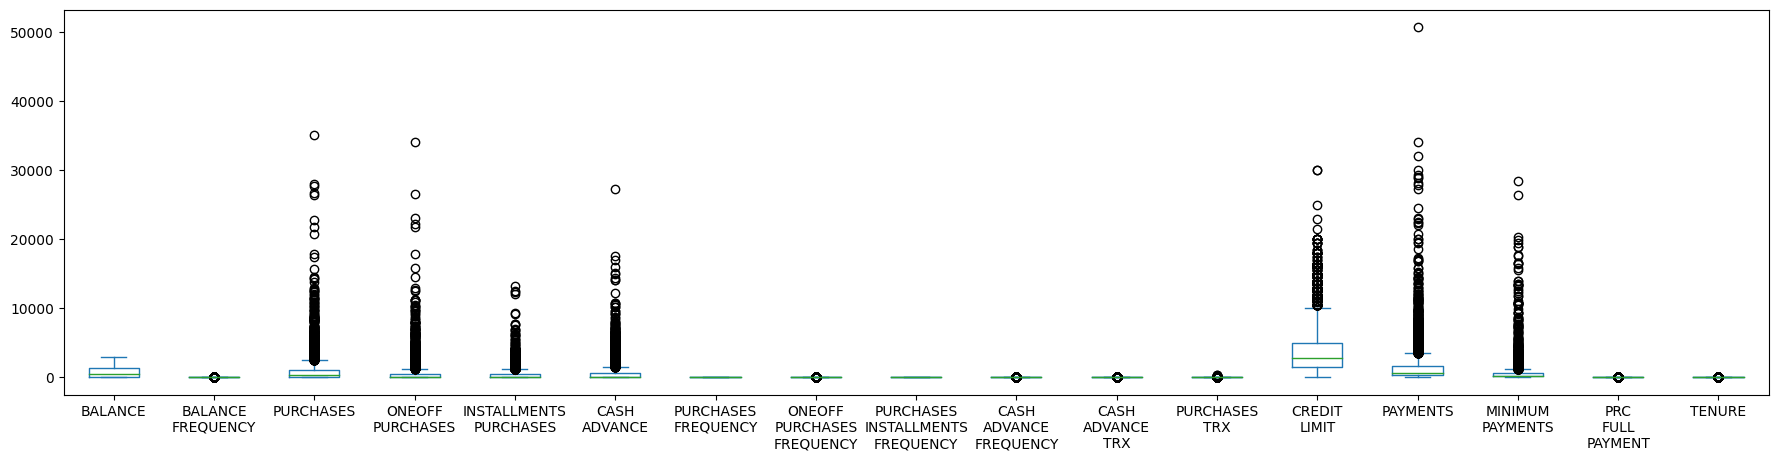

In [18]:
cols = df.columns[1:]

def iqr (df) :
  for col in cols :
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1

    lower = q1 - iqr * 1.5
    upper = q1 + iqr * 1.5

    return_df = df[(df[col]>= lower) & (df[col] <= upper) ]
    return return_df

# 전체이상치
df_f3 = iqr(df)

df_f3 = df_f3.drop(columns = ['CUST_ID'], axis =1 )
fig, ax = plt.subplots(figsize = (22, 5))

df_f3.columns = [x.replace('_','\n') for x in df_f3.columns]
df_f3.plot(kind = 'box', ax = ax)

PCA를 통해 적절한 차원으로 데이터를 축소하고 평가하라

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16
ratio,0.282558,0.174652,0.097286,0.081473,0.062283,0.057845,0.045724,0.043558,0.038482,0.030296,0.022950,0.019863,0.01610,0.013344,0.011112,0.002472,0.000001
cumsum,0.282558,0.457210,0.554496,0.635969,0.698252,0.756097,0.801821,0.845379,0.883861,0.914157,0.937107,0.956971,0.97307,0.986415,0.997527,0.999999,1.000000


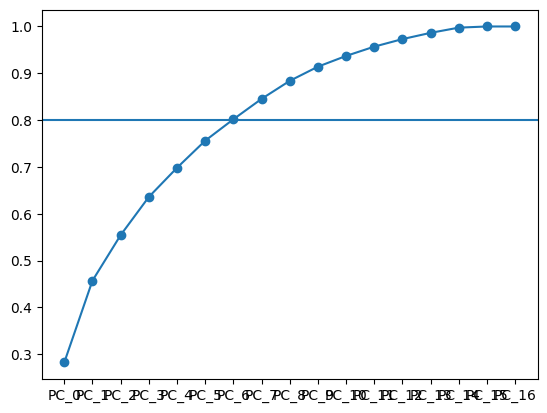

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

scaled_df = ss.fit_transform(df_f3)


pca = PCA()
pca.fit(scaled_df)

pca_check = pd.DataFrame(
{'ratio' : pca.explained_variance_ratio_ ,
 'cumsum' :  pca.explained_variance_ratio_.cumsum()}
)

pca_check.index = ['PC_' + str(i) for i in range(len(pca_check.index))]

display(pca_check.T)
plt.plot(pca_check['cumsum'], 'o-')
plt.axhline(y = 0.80)
plt.show()

In [20]:
pca_8 = PCA(n_components= 8)
pca_8.fit(scaled_df)

pca_df = pd.DataFrame(pca_8.transform(scaled_df))

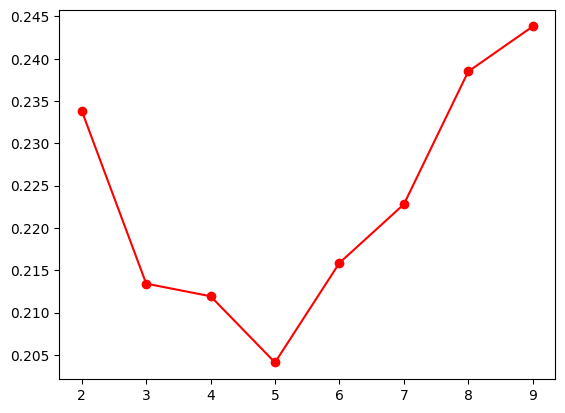

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score , silhouette_samples


lst =[]
sil_lst = []
k_range = range(2, 10)

for K in k_range :
  kmeans = KMeans(n_clusters = K, random_state =123 , n_init = 10)
  kmeans.fit(pca_df)

  lst.append(kmeans.inertia_)
  sil_lst.append(silhouette_score(pca_df, kmeans.labels_))


plt.plot(k_range, sil_lst, 'ro-')


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: >

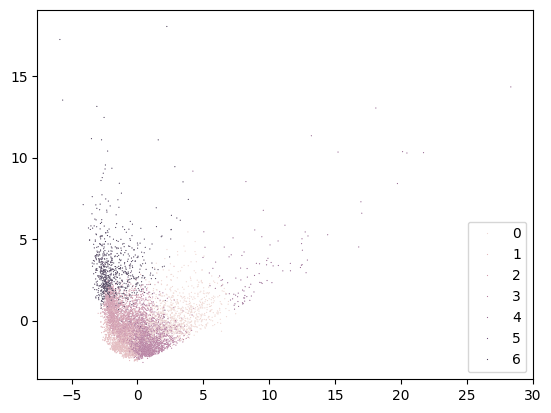

In [22]:
km = KMeans(n_clusters= 7 ,random_state = 1234)
km.fit(pca_df)

km_label = km.predict(pca_df)

import seaborn as sns
sns.scatterplot(x = pca_df.values[:,0], y = pca_df.values[:,1], hue = km_label, s =0.7)

In [23]:
kmean_df = pca_df.iloc[:,:2]
kmean_df.columns = ['PC1', 'PC2']
kmean_df['Label'] = km_label
kmean_df

# 실루엣 계수
s_score = silhouette_samples(kmean_df[['PC1', 'PC2']], kmean_df['Label'])


print(silhouette_score(kmean_df[['PC1','PC2']], kmean_df['Label']))

<ipython-input-23-5ab899d1812e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kmean_df['Label'] = km_label


0.16604846864177886


병합적 계층군집을 실시하고 덴드로그램을 시각화하라. 군집간 거리는 ward 방식으로 업데이트하며 위 문제에서 구한 최적 군집 갯수가 만들어지 지기 위한 거리 범위를 구하라

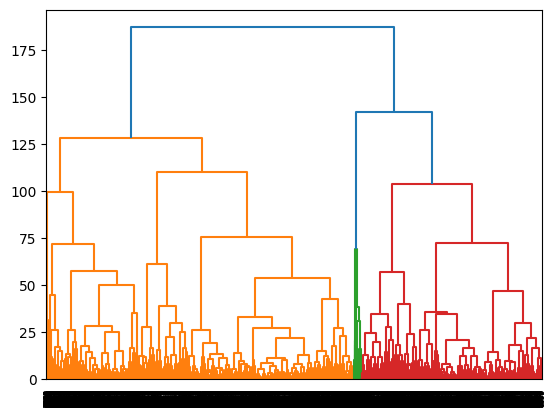

In [24]:
from scipy.cluster.hierarchy import dendrogram , linkage

link = linkage(pca_df, 'ward')
d = dendrogram(link)


어느 자동차 회사의 본사에서 여러 지방 영업소에 내려보낸 43대의 새 차 중 11대에 불량 오디오가 설치되었다고 한다. 어느 영업소가 8대를 인수하였는데 이 중에서 오디오가 불량인 차가 적어도 2대 이상이 될 확률을 구하라.

In [25]:

from scipy.stats import hypergeom
rv = hypergeom(43, 11, 8)

# x >= 2

1 - rv.pmf(0) - rv.pmf(1)

0.6721384488647228

변수들의 다중공선성을 검토

In [26]:
df = pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SONY/ADP_SET_1/data/stats_reg1.csv')


from statsmodels.stats.outliers_influence import variance_inflation_factor

df1 = df.drop(columns = 'Target', axis = 1)


vif = pd.DataFrame()
vif['factor'] = [variance_inflation_factor(df1.values, i) for i in range(df1.shape[1])]
vif['features'] = df1.columns
vif.T


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
factor,44.238222,14.524559,2.101471,1.859888,2.19566,1.142734,1.200195,1.08955,1.190482,5.828291,139.71521,141.201961,46.388666,2.840278,2.294972
features,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,F_11,F_12,F_13,F_14,F_15


다중공선성 문제를 해결하기 위한 방법 2가지를 제시하고

In [29]:
# 1. PCA - 차원 축소를 통해서 변수간 상관성을 줄인다.
# 2. Corr - 상관변수가 높은 것들을 제거한다.

cor = df1.corr().unstack().reset_index()
cor.columns = ['cor1', 'cor2','corr']
cor_filter = cor[cor['corr'] != 1].sort_values('corr')[::2].reset_index(drop = True)
cor_filter

,cor1,cor2,corr
0,F_9,F_2,-0.333773
1,F_2,F_1,-0.257508
2,F_7,F_4,-0.254480
3,F_6,F_5,-0.151907
4,F_8,F_11,-0.135043
...,...,...,...
100,F_14,F_4,0.492349
101,F_3,F_14,0.578762
102,F_5,F_15,0.707201
103,F_13,F_1,0.840241


통계2-3
2-2의 방법을 전,후의 회귀 분석 모델의 결과를 비교

In [35]:
import statsmodels.api as sm

before = df.drop(columns = 'Target')
After = df.drop(columns = ['Target', 'F_1','F_11'])

X1 = sm.add_constant(before)
model_pre = sm.OLS(df['Target'], X1).fit()


X2 = sm.add_constant(After)
model_pre = sm.OLS(df['Target'], X2).fit()

통계 3
data_path = ./data/learn.csv

어느 학급의 학생들이 3가지(Lecture,Online,Blended)방식으로 학습하고 시험을 본 결

In [43]:
df = pd.read_csv('/content/drive/MyDrive/ADP_SONY/ADP_SONY/ADP_SET_1/data/learn.csv')

from scipy.stats import shapiro, levene

lc = df['Lecture']
on = df['Online']
bl = df['Blended']

s, p_lc = shapiro(lc)
s, on_lc = shapiro(on)
s, bl_lc = shapiro(bl)

s, p = levene(lc, on, bl)

print(f'''
Shapiro 정규성 검정 시, {p_lc} , {on_lc} , {bl_lc}으로 결론이 나왔다.
귀무가설은 정규성을 만족한다. 대립가설은 정규성을 만족하지 않는다. Lecture방식만 유의 수준 0.05 하에
대립 가설을 채택하며 정규성을 만족하지 않는다.

Levene 검정을 통해 등분산 검정을 시행했다. 귀무가설은 등분산이다/ 대립가설은 등분산을 만족하지 않는다 이다.
{p} < 유의수준 a (0.05)이기 때문에 귀무가설을 기각한다.  즉 3컬럼 중 하나의 컬럼이 등분산을 만족하지 않는다
''')


Shapiro 정규성 검정 시, 0.004649894752187412 , 0.9098541576461749 , 0.363977798323533으로 결론이 나왔다. 
귀무가설은 정규성을 만족한다. 대립가설은 정규성을 만족하지 않는다. Lecture방식만 유의 수준 0.05 하에
대립 가설을 채택하며 정규성을 만족하지 않는다. 

Levene 검정을 통해 등분산 검정을 시행했다. 귀무가설은 등분산이다/ 대립가설은 등분산을 만족하지 않는다 이다. 
5.894135513581264e-05 < 유의수준 a (0.05)이기 때문에 귀무가설을 기각한다.  즉 3컬럼 중 하나의 컬럼이 등분산을 만족하지 않는다



통계 3-2
위 결과에 맞는 그룹간 점수 분포 차이가 존재하는지를 확인하는 통계 검정 전략을 설명하라

비모수 프리드먼

In [47]:
from scipy.stats import friedmanchisquare

s,  p = friedmanchisquare(df['Lecture'] , df['Online'], df['Blended'])

print(f'''
귀무가설 : 3가지 방법 간이 차이가 없다.
대립가설 : 적어도 하나의 방식에 차이가 있다.
검정결과 {p} < 유의 수준 a (0.05)이기 떄문에, 귀무가설을 기각하며, 즉 적어도 하나의 방식에는 차이가 존재하며
사후 분석을 통해 어떤 그룹에서 차이가 나는지 알아봐야한다.
''')


귀무가설 : 3가지 방법 간이 차이가 없다. 
대립가설 : 적어도 하나의 방식에 차이가 있다. 
검정결과 4.575338769445776e-08 < 유의 수준 a (0.05)이기 떄문에, 귀무가설을 기각하며, 즉 적어도 하나의 방식에는 차이가 존재하며
사후 분석을 통해 어떤 그룹에서 차이가 나는지 알아봐야한다. 

